### This notebook dedicated to draft a code for EMG emulation from a file 

In [1]:
import time
import uuid

from matplotlib import pyplot as plt
from mne import set_log_level

from mne_lsl.datasets import sample
from mne_lsl.player import PlayerLSL as Player
from mne_lsl.stream import StreamLSL as Stream

set_log_level("WARNING")

In [19]:
source_id = uuid.uuid4().hex
fname = sample.data_path() / "sample-ant-raw.fif"
player = Player(fname, chunk_size=200, source_id=source_id).start()
player.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 63 EEG, 2 EOG, 1 Galvanic skin response, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 68
 projs: []
 sfreq: 1024.0 Hz
>

In [3]:
sfreq = player.info["sfreq"]
chunk_size = player.chunk_size
interval = chunk_size / sfreq  # in seconds
print(f"Interval between 2 push operations: {interval} seconds.")

NameError: name 'player' is not defined

In [21]:
stream = Stream(bufsize=2, source_id=source_id).connect()
stream.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 63 EEG, 2 EOG, 1 Galvanic skin response, 1 ECG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 68
 projs: []
 sfreq: 1024.0 Hz
>

In [22]:
ch_types = stream.get_channel_types(unique=True)
print(f"Channel types included: {', '.join(ch_types)}")

Channel types included: eeg, eog, gsr, ecg, stim


In [23]:
stream.pick("eeg")  # channel selection
assert "CPz" not in stream.ch_names  # reference absent from the data stream
stream.add_reference_channels("CPz")
stream.set_eeg_reference("average")
stream.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 64 EEG
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

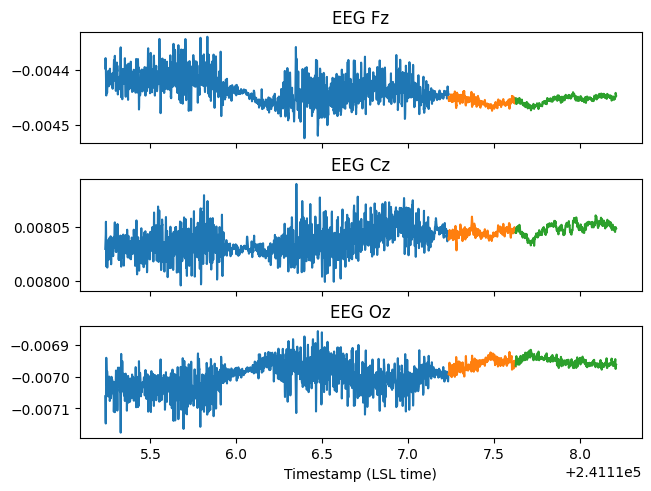

In [25]:
picks = ("Fz", "Cz", "Oz")  # channel selection
f, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True)
for _ in range(3):  # acquire 3 separate window
    # figure how many new samples are available, in seconds
    winsize = stream.n_new_samples / stream.info["sfreq"]
    # retrieve and plot data
    data, ts = stream.get_data(winsize, picks=picks)
    for k, data_channel in enumerate(data):
        ax[k].plot(ts, data_channel)
    time.sleep(0.5)
for k, ch in enumerate(picks):
    ax[k].set_title(f"EEG {ch}")
ax[-1].set_xlabel("Timestamp (LSL time)")
plt.show()

In [26]:
stream.disconnect()

<Stream: OFF | MNE-LSL-Player (source: 40b97c44a85c41f2b935c0eba51860d3)>

In [27]:
player.stop()

<Player: MNE-LSL-Player | OFF | C:\Users\gorin\mne_data\MNE-LSL-data\sample\sample-ant-raw.fif>

In [3]:
import time
import numpy as np
import mne
import threading
from pylsl import StreamInfo, StreamOutlet, StreamInlet, resolve_streams
from scipy.signal import butter, filtfilt, find_peaks
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui


In [5]:
def stream_edf_loop(filename, channel_name="PPG", stream_name="EDF_PPG", stop_event=None):
    
    """Бесконечно стримит EDF-файл в LSL, пока stop_event не выставлен."""
    
    raw = mne.io.read_raw_edf(filename, preload=True)
    
    if channel_name not in raw.ch_names:
        raise ValueError(f"Канал {channel_name} не найден в EDF!")
    
    data = raw.get_data(picks=[channel_name])[0]
    
    fs = int(raw.info['sfreq'])

    info = StreamInfo(stream_name, 'PPG', 1, fs, 'float32', 'ppg_loop_stream')
    
    outlet = StreamOutlet(info)

    print(f"[STREAM] Поток {stream_name} запущен (канал={channel_name}, fs={fs} Гц)")
    
    while not stop_event.is_set():
        for sample in data:
            if stop_event.is_set():
                break
            outlet.push_sample([float(sample)])
            time.sleep(1.0 / fs)
            
    print(f"[STREAM] Поток {stream_name} остановлен.")


# глобальные переменные для управления
stream_thread = None
stop_event = None

def start_stream(filename, channel_name="PPG", stream_name="EDF_PPG"):
    
    """Запускает стриминг в отдельном потоке"""
    
    global stream_thread, stop_event
    
    stop_event = threading.Event()
    
    stream_thread = threading.Thread(
        target=stream_edf_loop,
        args=(filename, channel_name, stream_name, stop_event),
        daemon=True
    )
    
    stream_thread.start()
    
    print("[MAIN] Стриминг запущен.")

def stop_stream():
    """Останавливает стриминг"""
    global stop_event, stream_thread
    
    if stop_event is not None:
        stop_event.set()
        stream_thread.join()
        print("[MAIN] Стриминг остановлен.")


In [4]:
def show_stream(stream_name="EDF_PPG", fs=50, window_sec=10):
    
    streams = resolve_streams('name', stream_name)
    inlet = StreamInlet(streams[0])

    buffer_size = fs * window_sec
    data_buffer = np.zeros(buffer_size)

    %gui qt  # нужно в Jupyter, чтобы работало окно Qt
    app = QtGui.QApplication.instance() or QtGui.QApplication([])

    win = pg.GraphicsLayoutWidget(title="PPG real-time")
    plot = win.addPlot(title="PPG")
    curve = plot.plot(data_buffer, pen='g')
    plot.setYRange(-1, 1)
    win.show()

    def update():
        nonlocal data_buffer
        sample, ts = inlet.pull_sample(timeout=0.0)
        if sample:
            data_buffer = np.roll(data_buffer, -1)
            data_buffer[-1] = sample[0]
            curve.setData(data_buffer)

    timer = QtCore.QTimer()
    timer.timeout.connect(update)
    timer.start(20)

    app.exec_()


In [6]:
def get_heart_params(stream_name="EDF_PPG", fs=50, window_sec=20):
    
    streams = resolve_streams('name', stream_name)
    inlet = StreamInlet(streams[0])

    buffer = []
    while len(buffer) < fs * window_sec:
        sample, ts = inlet.pull_sample(timeout=1.0)
        if sample:
            buffer.append(sample[0])
    buffer = np.array(buffer)

    # фильтрация
    def bandpass_filter(sig, fs, low=0.5, high=8.0, order=3):
        nyq = 0.5 * fs
        b, a = butter(order, [low/nyq, high/nyq], btype='band')
        return filtfilt(b, a, sig)

    signal = bandpass_filter(buffer, fs)
    peaks, _ = find_peaks(signal, distance=int(0.4*fs), prominence=0.2)

    if len(peaks) < 2:
        return None

    ibi = np.diff(peaks) / fs
    hr = 60.0 / np.mean(ibi)
    sdnn = np.std(ibi)
    rmssd = np.sqrt(np.mean(np.square(np.diff(ibi)))) if len(ibi) > 1 else None

    return {"HR": hr, "SDNN": sdnn, "RMSSD": rmssd}


In [ ]:
filename = r'F:\Science\HSE_unofficial\Myointerface\Data\PPG\PL_10_21082025_.edf'

# 🚀 1. Запускаем стриминг EDF
start_stream(filename, channel_name="PPG", stream_name="EDF_PPG")

# 🚀 2. Показываем сигнал
show_stream("EDF_PPG", fs=50, window_sec=10)

# 🚀 3. Считаем HR/HRV
# params = get_heart_params("EDF_PPG", fs=50, window_sec=20)
# print(params)




[MAIN] Стриминг запущен.


TypeError: resolve_streams() takes from 0 to 1 positional arguments but 2 were given

Extracting EDF parameters from F:\Science\HSE_unofficial\Myointerface\Data\PPG\PL_10_21082025_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 47249  =      0.000 ...   188.996 secs...
[STREAM] Поток EDF_PPG запущен (канал=PPG, fs=250 Гц)
[STREAM] Поток EDF_PPG остановлен.


In [8]:
# 🚀 4. Останавливаем стриминг
stop_stream()

[MAIN] Стриминг остановлен.
